In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.stattools import adfuller

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
payload_hex = "../Datasets/dataset_TPV_sensors/hex/payloadHex.csv"

df = pd.read_csv(payload_hex)

print(df.shape[0])

df = df.dropna()


#df["Time"] = pd.to_datetime(df['Time'])
x_time = pd.date_range("2018-01-01", periods=df.shape[0],freq="H")

print(df.shape[0])
df["Time"] = x_time
df.head()

92554
92554


,InletPressure,OutletPressure,OutletTemperature,InverterSpeed,Time
0,16.930580,1011.139771,83.308502,4552.0,2018-01-01 00:00:00
1,17.123455,1011.230347,83.308502,4578.0,2018-01-01 01:00:00
2,16.737577,1010.567200,83.383270,4562.0,2018-01-01 02:00:00
3,16.930515,1010.898804,83.308502,4568.0,2018-01-01 03:00:00
4,16.834047,1010.868408,83.383270,4567.0,2018-01-01 04:00:00


In [3]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    for key,val in result[4].items():
        out[f'critical value ({key})']=val
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [4]:
adf_test(df["InletPressure"])
df = df.drop(labels=["Time"], axis=1)

In [33]:
split_test = 5000

#df['InletPressure'] = pd.to_numeric(df['InletPressure'], errors='coerce')

# df = df.drop(labels=["OutletPressure"], axis=1)

df["OutletTemperature"] = df["OutletTemperature"].astype(float)

train = df[:-split_test]
test = df[-split_test:]

In [34]:
df.dtypes

InletPressure        float64
OutletPressure       float64
OutletTemperature    float64
InverterSpeed        float64
dtype: object

In [35]:
from statsmodels.tsa.vector_ar.var_model import VAR

for i in range(20):
    model = VAR(train)
    results = model.fit(i)
    print('Order =', i)
    print('AIC: ', results.aic)
    print('BIC: ', results.bic)
    print()

Order = 0
AIC:  30.092607620756265
BIC:  30.093036156792305

Order = 1
AIC:  10.420109691214238
BIC:  10.422252393258315

Order = 2
AIC:  10.100185423869032
BIC:  10.104042326904205

Order = 3
AIC:  10.064180661785917
BIC:  10.06975180079637

Order = 4
AIC:  10.045544713503356
BIC:  10.052830123474395

Order = 5
AIC:  10.02499525261291
BIC:  10.033994968530976

Order = 6
AIC:  9.996506760181013
BIC:  10.007220817033671

Order = 7
AIC:  9.89901768602587
BIC:  9.91144611880181

Order = 8
AIC:  9.882888592378293
BIC:  9.897031436067337

Order = 9
AIC:  9.870183135762918
BIC:  9.886040425356011

Order = 10
AIC:  9.863338314921739
BIC:  9.880910085410958

Order = 11
AIC:  9.855123032164473
BIC:  9.874409318543018

Order = 12
AIC:  9.849047169089628
BIC:  9.870048006351832

Order = 13
AIC:  9.83581193427013
BIC:  9.858527357411448

Order = 14
AIC:  9.830397386804986
BIC:  9.854827430822004

Order = 15
AIC:  9.825520395835076
BIC:  9.85166509572551

Order = 16
AIC:  9.82276382474415
BIC:  9.8

In [36]:
result = model.fit(16)
result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 11, Apr, 2023
Time:                     16:02:17
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    9.85062
Nobs:                     87538.0    HQIC:                   9.83127
Log likelihood:          -926517.    FPE:                    18449.0
AIC:                      9.82276    Det(Omega_mle):         18394.3
--------------------------------------------------------------------
Results for equation InletPressure
                           coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------
const                        64.035459         3.253911           19.680           0.000
L1.InletPressure              1.554702         0.008770          177.272           0.000
L1.OutletPressure   

In [38]:
lagged_Values = train.values[-16:]
pred = result.forecast(y=lagged_Values, steps=split_test) 

#idx = pd.date_range('2015-01-01', periods=split_test, freq='MS')
df_forecast=pd.DataFrame(data=pred, columns=['InletPressure_forecast',
                                                        'OutletPressure_forecast',
                                                        'OutletTemperature_forecast',
                                                        'InverterSpeed_forecast'])

((5000,), (5000,))


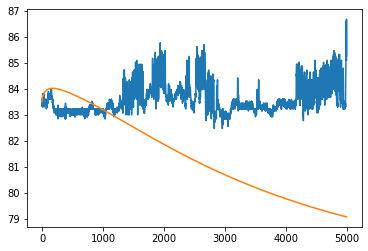

In [42]:
test_original = df[-split_test:]
test_original.index = pd.to_datetime(test_original.index)

#'InletPressure',
#'OutletPressure',
#'OutletTemperature',
#'InverterSpeed'

feature = 'OutletTemperature'

print((test_original[feature].shape,
       df_forecast[f'{feature}_forecast'].shape))

# test_original['InletPressure'].plot(figsize=(12,5),legend=True)
# df_forecast['InletPressure_forecast'].plot(legend=True)
plt.plot(test_original[feature].tolist())
plt.plot(df_forecast[f'{feature}_forecast'].tolist())

In [ ]:
df_forecast['OutletPressure_forecast'], df_forecast['OutletPressure_forecast']

### Filter signal avoid loss Amplitude.

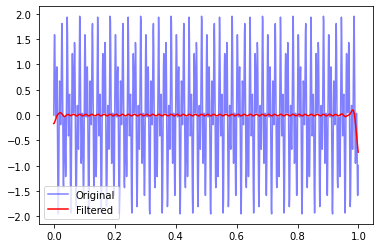

In [43]:
import numpy as np
from scipy.signal import butter, filtfilt

# create a sample 1D signal
fs = 1000  # sampling frequency
t = np.linspace(0, 1, fs, endpoint=False)
x = np.sin(2*np.pi*50*t) + np.sin(2*np.pi*120*t)

# define the filter parameters
order = 4
cutoff_freq = 30  # Hz
nyquist_freq = 0.5 * fs
normal_cutoff_freq = cutoff_freq / nyquist_freq
b, a = butter(order, normal_cutoff_freq, btype='low', analog=False)

# apply zero-phase filtering
y = filtfilt(b, a, x)

# plot the original and filtered signals
import matplotlib.pyplot as plt

plt.figure()
plt.plot(t, x, 'b', alpha=0.5)
plt.plot(t, y, 'r')
plt.legend(['Original', 'Filtered'])
plt.show()